# Sentence Embeddings

## Introduction

There are 3 kinds of transformer architectures - Encoder only (BERT, its variants), Decoder only (GPT, its variants) and Encoder-Decoder (T5, its variants) as is well known



For Encoder architectures, we saw in the sentence transformer notebook how to get sentence embeddings - Do a mean pooling operation on the word level embeddings after passing a sentence through a BERT, and train using a two tower or a three tower contrastive loss (Siamese or triplet loss)

How do we get sentence embeddings for Decoder architectures (GPT variants) and Encoder-decoder architectures (T5 variants) ?

## Decoder architectures (GPT)

[Here](https://cdn.openai.com/papers/Text_and_Code_Embeddings_by_Contrastive_Pre_Training.pdf) is the paper describing how to get sentence embeddings for GPT- openAI


Decoder models don't naturally learn embeddings of words unlike an encoder model (TODO Why ? This is because  encoder only models are bidirectional, and at inference time, given a sentence, they give an vector representation of every word at the output layer. So every word gets a vector representation).
1) For decoder only models, first of all they are uni-directional and can't peek into the future. So a word can look only at its past, which means the representation of an individual word after passing through the decoder layers at the final layer is conditional only on the past words. This is especially bad for the first word , or words early in the sentence, as they can look at words before only. Which means they have minimal context to get a good word embedding
2) Also, at inference time, you don't get the representations of all words in a sentence in one pass. First get the first word, take that as an input, get the second word and so on until you get the stop top. This point is more operational


In any case, the way the paper above from OpenAI handles the fundamental limitation of not not getting embeddings directly is to use an encoder model instead of the decoder model (drumbeat !! ), and training it using contrastive loss (very similar to the sentence transformers architecture). The main difference , as far as I can tell, is that they initialize the encoder architecure with weights obtained from a GPT-3 pretrained decoder model; and then go ahead and finetune the initialized encoder using contrastive loss (https://ai.stackexchange.com/questions/41161/how-can-an-decoder-only-transformer-be-used-for-document-embedding#:~:text=1%20Answer&text=The%20GPT%20models%20(as%20manifested,%5D%2C%20that%20can%20create%20embeddings.)

## Encoder-Decoder architectures (T5)

Again, it is not completely intuitive how encoder-decoder architectures like T5 can naturally be used to obtain sentence embeddings unlike an encoder only model.

Here's a paper from google on exactly this topic https://arxiv.org/abs/2108.08877 (They call this sentence T5)

They tested the quality of embededings from these methods on the usual suspects for evaluating sentence embeddings - SentEval, and STS (Sentence/Semantic text similarity tasks), and saw improvements just using the pretrained T5 model without any finetuning. 

They subsequently finetuned on NLI and ReQA ( Retrieval question answering tasks) using the usual dual encoder contrastive learning framework and found still further improvements

How do they do this ?
They talk about three variants

1) Taking the first token representation from the encoder part of the encoder-decoder
2) averaging all the token representations from the encoder part of the encoder-decoder
3) Taking the first token representation of the Decoder part of the encoder-decoder. To obtain the decoder output, the input text is fed into the encoder, and the standard “start” symbol is fed as the first decoder input.


Note that 1) and 2) are pretty much similar to what you would do in an encoder only architecture to get sentence embeddings, except here the encoder-decoder was trained jointly, and we are picking the sentence embedding from the encoder part

There's one other minor difference for 1)  . T5 models don't use a CLS token unlike BERT, so the first actual sentence token is taken.

On method 3) The hope is that since this is an encoder-decoder architecture , the first token of the decoder, the start symbol has the entire encoder representation

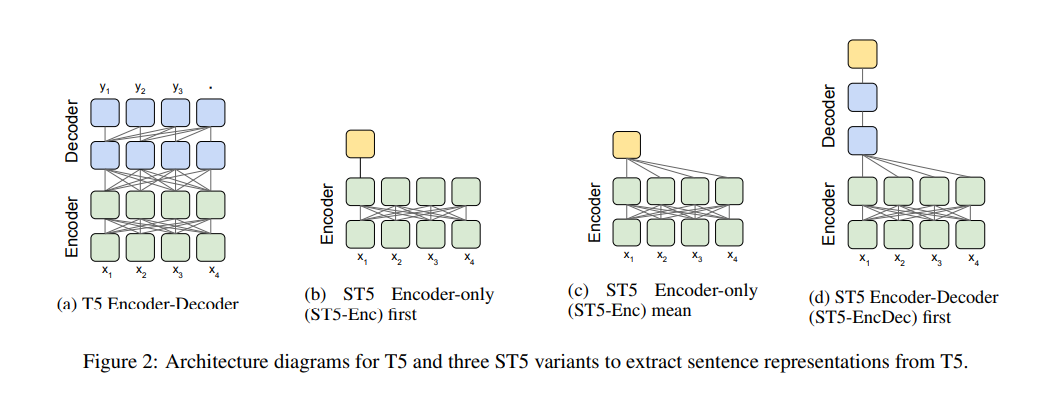

Here's a diagram from figure 2 in the paper above talking about the 3 methods


For finetuning (similar to what sentenceBERT had done), they used the standard two-tower / dual encoder approach. Here, they tried just using 2 encoder, or using 2 encoder-decoder depending on the method above(The encoder or enc-dec initialized from the pretrained T5). 
They take the sentence embedding (from one of the 3 methods above), apply a projection layer (to transform the embedding to a desired final size) and L2 normalization, then then the 2 embeddings thus obtained from the sentence pairs are scored using a dot product/cosine distance, or fed to a classification layer for NLI classification (similar to what we saw in sentence BERT)

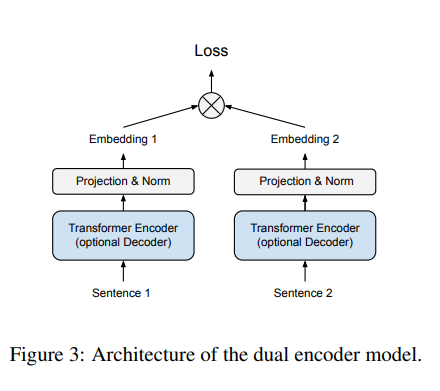

The loss function used was contrastive loss - They experimented with just positive pairs, or anchor, positive , negative, leading to formulations similar to what we saw earlier with sentenceBERT (InfoNCR/NTXent)

With only positive pairs or similar pairs, used this loss function


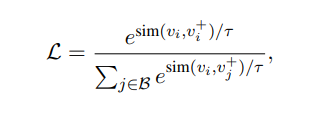


With triplet (positive, negative, anchor), used this loss function


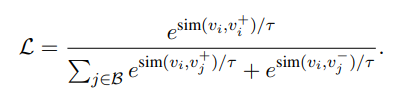

Results : When mean pooling is applied to the T5’s encoder outputs (method 2 above), it greatly outperforms the average embeddings of BERT (without even finetuning)

## Comparison between these 3 variants

https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9  is a comparison article for all 3 architectures - OpenAI GPT, Sentence BERT and sentence T5 (benchmarking was done in Jan 2022)

### Sentence Embedding Performance



On a benchmark of 14 tasks spanning
a) Paraphrase detection: (Paraphrase means rewording). Scoring of text pairs if they are paraphrases. Evaluated on  SprintDuplicateQuestions (questions pairs from the Sprint technical forum), and on TwitterSemEval2015 & TwitterURLCorpus (annotated paraphrase pairs of Tweets).
b) Clustering : Clustering of similar sentences into topics. Evaluated Reddit (cluster reddit titles into subreddits), 20NewsGroups (cluster email subjects into topics), and StackExchange (cluster questions into topics)
c) Retrieval : Given a sentence, find related sentences. Evaluated on CQADupStack (finding similar questions on different StackExchange forums), Quora (find related questions on Quora), AskUbuntu (find helpful questions on AskUbuntu), StackOverflowDupQuestions (find duplicate questions on StackOverflow), and SciDocs (find related scientific papers based on titles).
d) STS/Semantic Textual Similarity : Annotating text pairs on 0-1 based on similarity. Evaluated on BIOSSES (biomedical text pair, STS benchmark and SICK-R)

Here are the numbers on sentence embedding performance

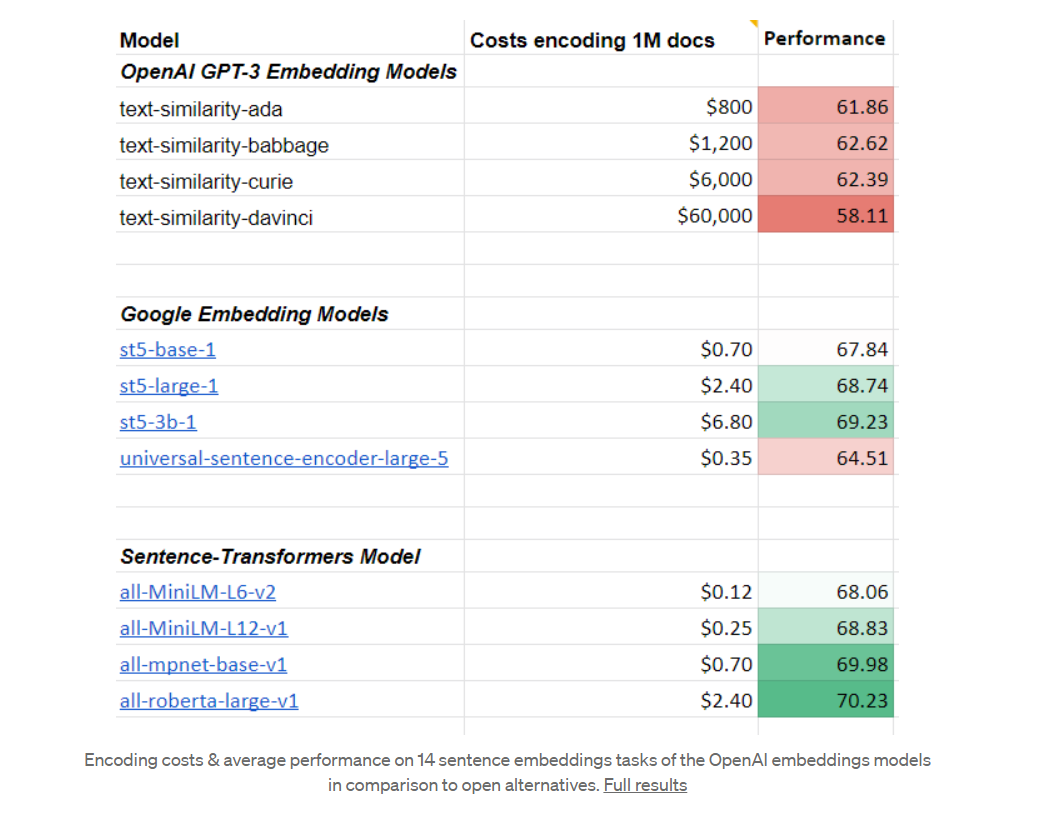



"Sentence similarity models from OpenAI perform a lot worse than models such as the Universal Sentence Encoder, which was published in March 2018, and also much worse than the state-of-the-art models from sentence-transformers & Sentence-T5, and are a lot more expensive !!"

For example, da-vinci (175B parameters) is worse than all-MiniLM-L6-v2 which is a 22M parameter model (this is a distilled BERT model)

### Text Search Performance

The openAI paper reports performance for retrieval on BEIR for 11 of the 18 datasets (zero shot information retrieval)

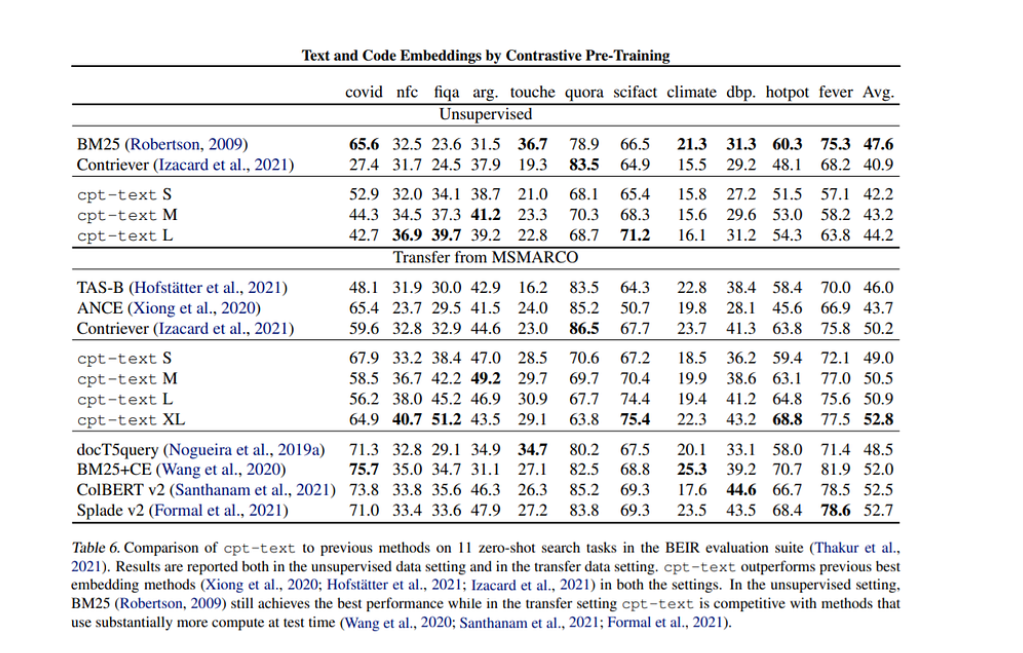



In the medium article above, Nils reported these numbers

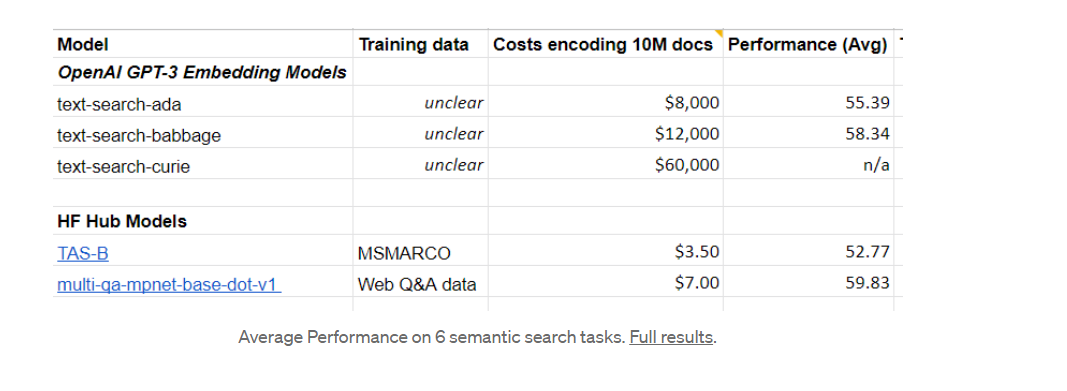

The performance of openAI search models is not bad (comparable to dense models) but much more expensive

Conclusion : """The text similarity models are weaker than e.g. Universal Sentence Encoder from 2018 and much weaker than text embedding models from 2021. They are even weaker than the all-MiniLM-L6-v1 model, which is so small & efficient that it can run in your browser.

The text-search models perform much stronger, achieving good results. But they are just on-par with open models like SPLADEv2 or multi-qa-mpnet-base-dot-v1.

The biggest downside for the OpenAI embeddings endpoint is the high costs (about 8,000–600,000 times more expensive than open models on your infrastructure), the high dimensionality of up to 12288 dimensions (making downstream applications slow), and the extreme latency when computing embeddings. This hinders the actual usage of the embeddings for any search applications"""

## References

1) https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9 - Comparison between embeddings from GPT, BERT, and T5
2) https://cdn.openai.com/papers/Text_and_Code_Embeddings_by_Contrastive_Pre_Training.pdf
3) https://arxiv.org/abs/2108.08877